## Imports

In [1]:
from datetime import datetime
import numpy as np
import os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp

## Load Data
- Variable: 2m dewpoint temperature ('d2m'), 2m temperature ('t2m'), Snowfall ('sf'), Total precipitation ('tp')
- Year: 2019
- Months: All
- Day: 15
- Time: 1:00-23:00
- Sub-region extraction: North 85°, West -170°, South 40°, East -50°

In [2]:
# Prepare model re-analysis data
era5_file = 'Datasets/23hrs.nc'
DS = xr.open_dataset(era5_file)

In [3]:
DS

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 1201, time: 276)
Coordinates:
  * longitude  (longitude) float32 -170.0 -169.9 -169.8 ... -50.2 -50.1 -50.0
  * latitude   (latitude) float32 85.0 84.9 84.8 84.7 ... 40.3 40.2 40.1 40.0
  * time       (time) datetime64[ns] 2019-01-15T01:00:00 ... 2019-12-15T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sf         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-15 20:27:40 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [4]:
# Convert total precipitation + snowfall from m to mm
DS.tp.values = DS.tp.values * 1000
DS.sf.values = DS.sf.values * 1000

## Convert to Dataframe
- Multi-indexed on lat/long and time (station/time)
- Appears to have a significant proportion of null values

In [5]:
ds = DS.to_dataframe()
ds

d2m  t2m  sf  tp
latitude longitude time                                 
85.0     -170.0    2019-01-15 01:00:00  NaN  NaN NaN NaN
                   2019-01-15 02:00:00  NaN  NaN NaN NaN
                   2019-01-15 03:00:00  NaN  NaN NaN NaN
                   2019-01-15 04:00:00  NaN  NaN NaN NaN
                   2019-01-15 05:00:00  NaN  NaN NaN NaN
...                                     ...  ...  ..  ..
40.0     -50.0     2019-12-15 19:00:00  NaN  NaN NaN NaN
                   2019-12-15 20:00:00  NaN  NaN NaN NaN
                   2019-12-15 21:00:00  NaN  NaN NaN NaN
                   2019-12-15 22:00:00  NaN  NaN NaN NaN
                   2019-12-15 23:00:00  NaN  NaN NaN NaN

[149495676 rows x 4 columns]

## Data Preprocessing

In [6]:
# Drop null values -> represent ocean, which is not measured in this dataset
ds_dropped = ds.dropna()
# ds_dropped.drop_duplicates(inplace=True) # NOT REQUIRED FOR THIS DATA

In [7]:
ds_dropped

d2m         t2m        sf  \
latitude  longitude  time                                                    
83.099998 -74.500000 2019-01-15 01:00:00  242.789154  245.809418  0.019545   
                     2019-01-15 02:00:00  242.598068  245.812210  0.040788   
                     2019-01-15 03:00:00  242.674988  245.763428  0.061184   
                     2019-01-15 04:00:00  242.836029  245.763428  0.088375   
                     2019-01-15 05:00:00  242.796371  245.721634  0.121515   
...                                              ...         ...       ...   
40.000000 -74.099998 2019-12-15 19:00:00  273.658966  281.814392  0.000000   
                     2019-12-15 20:00:00  272.386200  281.190125  0.000000   
                     2019-12-15 21:00:00  270.993256  280.280212  0.000000   
                     2019-12-15 22:00:00  269.815430  279.226776  0.000000   
                     2019-12-15 23:00:00  269.100311  278.447845  0.000000   

                                                tp  
latitude  longitude  time                           
83.099998 -74.500000 2019-01-15 01:00:00  0.019915  
                     2019-01-15 02:00:00  0.042316  
                     2019-01-15 03:00:00  0.062231  
                     2019-01-15 04:00:00  0.089612  
                     2019-01-15 05:00:00  0.121973  
...                                            ...  
40.000000 -74.099998 2019-12-15 19:00:00  0.059742  
                     2019-12-15 20:00:00  0.059742  
                     2019-12-15 21:00:00  0.060987  
                     2019-12-15 22:00:00  0.060987  
                     2019-12-15 23:00:00  0.060987  

[70386348 rows x 4 columns]

In [8]:
ds_dropped.reset_index(inplace=True)

# Filter out data points measured at 0:00 (we are only doing 12 hrs/day)
ds_dropped = ds_dropped.loc[ds_dropped['time'].dt.hour > 0]

ds_dropped['hourly_sf'] = ds_dropped['sf'].diff().fillna(ds_dropped['sf'])
ds_dropped['hourly_tp'] = ds_dropped['tp'].diff().fillna(ds_dropped['tp'])

In [9]:
ds_dropped['hourly_sf'] = np.where(ds_dropped['time'].dt.hour == 1, ds_dropped['sf'], ds_dropped['hourly_sf'])
ds_dropped['hourly_tp'] = np.where(ds_dropped['time'].dt.hour == 1, ds_dropped['tp'], ds_dropped['hourly_tp'])
ds_dropped

latitude  longitude                time         d2m         t2m  \
0         83.099998 -74.500000 2019-01-15 01:00:00  242.789154  245.809418   
1         83.099998 -74.500000 2019-01-15 02:00:00  242.598068  245.812210   
2         83.099998 -74.500000 2019-01-15 03:00:00  242.674988  245.763428   
3         83.099998 -74.500000 2019-01-15 04:00:00  242.836029  245.763428   
4         83.099998 -74.500000 2019-01-15 05:00:00  242.796371  245.721634   
...             ...        ...                 ...         ...         ...   
70386343  40.000000 -74.099998 2019-12-15 19:00:00  273.658966  281.814392   
70386344  40.000000 -74.099998 2019-12-15 20:00:00  272.386200  281.190125   
70386345  40.000000 -74.099998 2019-12-15 21:00:00  270.993256  280.280212   
70386346  40.000000 -74.099998 2019-12-15 22:00:00  269.815430  279.226776   
70386347  40.000000 -74.099998 2019-12-15 23:00:00  269.100311  278.447845   

                sf        tp  hourly_sf  hourly_tp  
0         0.019545  0.019915   0.019545   0.019915  
1         0.040788  0.042316   0.021243   0.022400  
2         0.061184  0.062231   0.020396   0.019915  
3         0.088375  0.089612   0.027191   0.027381  
4         0.121515  0.121973   0.033140   0.032362  
...            ...       ...        ...        ...  
70386343  0.000000  0.059742   0.000000   0.000000  
70386344  0.000000  0.059742   0.000000   0.000000  
70386345  0.000000  0.060987   0.000000   0.001244  
70386346  0.000000  0.060987   0.000000   0.000000  
70386347  0.000000  0.060987   0.000000   0.000000  

[70386348 rows x 9 columns]

In [10]:
# From Feiccabrino et al (https://westernsnowconference.org/sites/westernsnowconference.org/PDFs/2007Feiccabrino.pdf)
# Remove all observations w/ less than 0.1 mm SWE *try TP (0.04) instead
ds_dropped = ds_dropped.loc[abs(ds_dropped['hourly_tp']) >= 0.1]

In [11]:
ds_dropped

latitude  longitude                time         d2m         t2m  \
115       83.099998 -74.500000 2019-06-15 01:00:00  275.264648  277.069733   
116       83.099998 -74.500000 2019-06-15 02:00:00  275.134857  276.804993   
117       83.099998 -74.500000 2019-06-15 03:00:00  275.020691  276.607117   
118       83.099998 -74.500000 2019-06-15 04:00:00  274.918518  276.439911   
119       83.099998 -74.500000 2019-06-15 05:00:00  274.883667  276.381378   
...             ...        ...                 ...         ...         ...   
70386264  40.000000 -74.099998 2019-09-15 09:00:00  293.359894  294.433319   
70386265  40.000000 -74.099998 2019-09-15 10:00:00  293.462036  294.271698   
70386266  40.000000 -74.099998 2019-09-15 11:00:00  293.496887  294.185303   
70386267  40.000000 -74.099998 2019-09-15 12:00:00  293.571411  294.235474   
70386268  40.000000 -74.099998 2019-09-15 13:00:00  293.667572  294.788666   

           sf        tp  hourly_sf  hourly_tp  
115       0.0  0.134420        0.0   0.134420  
116       0.0  0.283770        0.0   0.149351  
117       0.0  0.433125        0.0   0.149354  
118       0.0  0.578743        0.0   0.145618  
119       0.0  0.731830        0.0   0.153087  
...       ...       ...        ...        ...  
70386264  0.0  2.175570        0.0   0.650927  
70386265  0.0  3.519744        0.0   1.344174  
70386266  0.0  4.511692        0.0   0.991948  
70386267  0.0  4.928638        0.0   0.416946  
70386268  0.0  5.100392        0.0   0.171754  

[9925001 rows x 9 columns]

In [12]:
ds_dropped.set_index(['latitude', 'longitude', 'time'], inplace=True)
ds_dropped.drop(['sf', 'tp'], axis=1, inplace=True)
ds_dropped

C:\Users\quintoj\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


d2m         t2m  hourly_sf  \
latitude  longitude  time                                                     
83.099998 -74.500000 2019-06-15 01:00:00  275.264648  277.069733        0.0   
                     2019-06-15 02:00:00  275.134857  276.804993        0.0   
                     2019-06-15 03:00:00  275.020691  276.607117        0.0   
                     2019-06-15 04:00:00  274.918518  276.439911        0.0   
                     2019-06-15 05:00:00  274.883667  276.381378        0.0   
...                                              ...         ...        ...   
40.000000 -74.099998 2019-09-15 09:00:00  293.359894  294.433319        0.0   
                     2019-09-15 10:00:00  293.462036  294.271698        0.0   
                     2019-09-15 11:00:00  293.496887  294.185303        0.0   
                     2019-09-15 12:00:00  293.571411  294.235474        0.0   
                     2019-09-15 13:00:00  293.667572  294.788666        0.0   

                                          hourly_tp  
latitude  longitude  time                            
83.099998 -74.500000 2019-06-15 01:00:00   0.134420  
                     2019-06-15 02:00:00   0.149351  
                     2019-06-15 03:00:00   0.149354  
                     2019-06-15 04:00:00   0.145618  
                     2019-06-15 05:00:00   0.153087  
...                                             ...  
40.000000 -74.099998 2019-09-15 09:00:00   0.650927  
                     2019-09-15 10:00:00   1.344174  
                     2019-09-15 11:00:00   0.991948  
                     2019-09-15 12:00:00   0.416946  
                     2019-09-15 13:00:00   0.171754  

[9925001 rows x 4 columns]

In [13]:
# Construct target variable: snow fraction
ds_dropped['snow_frac'] = ds_dropped['hourly_sf']/ds_dropped['hourly_tp']

try:
    assert ds_dropped['snow_frac'].max() == 1
    assert ds_dropped['snow_frac'].min() == 0
except:
    print("Invalid snow fraction values detected")
    
    # Ensure no values above 1
    ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 1 if x > 1 else x)
    assert ds_dropped['snow_frac'].max() == 1
    
    # Ensure no values below 1
    ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 0 if x < 0 else x)
    assert ds_dropped['snow_frac'].min() == 0
    print("Invalid snow fraction values fixed")

<ipython-input-13-4ab7b3fac7ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['snow_frac'] = ds_dropped['hourly_sf']/ds_dropped['hourly_tp']


Invalid snow fraction values detected


<ipython-input-13-4ab7b3fac7ba>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 1 if x > 1 else x)


Invalid snow fraction values fixed


<ipython-input-13-4ab7b3fac7ba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['snow_frac'] = ds_dropped['snow_frac'].map(lambda x: 0 if x < 0 else x)


In [14]:
# Convert dewpoint/air temperatures from Kelvin to degrees Celsius
ds_dropped['d2m'] = [i - 273.15 for i in ds_dropped['d2m']]
ds_dropped['t2m'] = [i - 273.15 for i in ds_dropped['t2m']]

<ipython-input-14-cf3d47ff7484>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['d2m'] = [i - 273.15 for i in ds_dropped['d2m']]
<ipython-input-14-cf3d47ff7484>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_dropped['t2m'] = [i - 273.15 for i in ds_dropped['t2m']]


In [15]:
ds_dropped

d2m        t2m  hourly_sf  \
latitude  longitude  time                                                   
83.099998 -74.500000 2019-06-15 01:00:00   2.114648   3.919733        0.0   
                     2019-06-15 02:00:00   1.984857   3.654993        0.0   
                     2019-06-15 03:00:00   1.870691   3.457117        0.0   
                     2019-06-15 04:00:00   1.768518   3.289911        0.0   
                     2019-06-15 05:00:00   1.733667   3.231378        0.0   
...                                             ...        ...        ...   
40.000000 -74.099998 2019-09-15 09:00:00  20.209894  21.283319        0.0   
                     2019-09-15 10:00:00  20.312036  21.121698        0.0   
                     2019-09-15 11:00:00  20.346887  21.035303        0.0   
                     2019-09-15 12:00:00  20.421411  21.085474        0.0   
                     2019-09-15 13:00:00  20.517572  21.638666        0.0   

                                          hourly_tp  snow_frac  
latitude  longitude  time                                       
83.099998 -74.500000 2019-06-15 01:00:00   0.134420        0.0  
                     2019-06-15 02:00:00   0.149351        0.0  
                     2019-06-15 03:00:00   0.149354        0.0  
                     2019-06-15 04:00:00   0.145618        0.0  
                     2019-06-15 05:00:00   0.153087        0.0  
...                                             ...        ...  
40.000000 -74.099998 2019-09-15 09:00:00   0.650927        0.0  
                     2019-09-15 10:00:00   1.344174        0.0  
                     2019-09-15 11:00:00   0.991948        0.0  
                     2019-09-15 12:00:00   0.416946        0.0  
                     2019-09-15 13:00:00   0.171754        0.0  

[9925001 rows x 5 columns]

## Examine Variable Distributions

In [16]:
ds_final = ds_dropped[['d2m', 't2m', 'snow_frac']]

In [17]:
ds_final

d2m        t2m  snow_frac
latitude  longitude  time                                                
83.099998 -74.500000 2019-06-15 01:00:00   2.114648   3.919733        0.0
                     2019-06-15 02:00:00   1.984857   3.654993        0.0
                     2019-06-15 03:00:00   1.870691   3.457117        0.0
                     2019-06-15 04:00:00   1.768518   3.289911        0.0
                     2019-06-15 05:00:00   1.733667   3.231378        0.0
...                                             ...        ...        ...
40.000000 -74.099998 2019-09-15 09:00:00  20.209894  21.283319        0.0
                     2019-09-15 10:00:00  20.312036  21.121698        0.0
                     2019-09-15 11:00:00  20.346887  21.035303        0.0
                     2019-09-15 12:00:00  20.421411  21.085474        0.0
                     2019-09-15 13:00:00  20.517572  21.638666        0.0

[9925001 rows x 3 columns]

In [ ]:
# ds_final.to_csv('ERA5_Land_processed.csv')

In [ ]:
# f = plt.figure(figsize=(20,6))
# ax = f.add_subplot(121)
# ax2 = f.add_subplot(122)
# ax.scatter(ds_final['t2m'], ds_final['snow_frac'], marker='o', edgecolor='white', linewidth=0.3)
# ax.set_xlabel('Air Temperature')
# ax.set_ylabel('Snow Fraction')
# ax2.scatter(ds_final['d2m'], ds_final['snow_frac'], marker='o', edgecolor='white', linewidth=0.3)
# ax2.set_xlabel('Dew Point Temperature')

## Train-Test Split
- Split by year:
    - 2010-2020
    - Latest 30% of data points for testing
    - Oldest 70% of data points for training
- To be used later for bivariate analysis:
    - Should be used for the logistic/isotonic fitting that follows

In [ ]:
# ds_ = ds_final.reset_index()
# ds_['time'] = pd.to_datetime(ds_['time'])
# ds_train = ds_[ds_['time'].dt.month <= 9].set_index(['latitude', 'longitude', 'time'])
# ds_test = ds_[ds_['time'].dt.month > 9].set_index(['latitude', 'longitude', 'time'])

In [ ]:
# y_train = ds_train['snow_frac']
# y_test = ds_test['snow_frac']

# X_train = ds_train.drop(['snow_frac'], axis=1)
# X_test = ds_test.drop(['snow_frac'], axis=1)

## Data Transformation
- Data standardization for later, may not need since we cannot see the actual range of values for d2m and t2m

In [ ]:
# from sklearn.preprocessing import RobustScaler
# pt = RobustScaler().fit(np.array(X_train))

# X_train_norm = pt.transform(np.array(X_train))
# X_test_norm = pt.transform(np.array(X_test))

In [ ]:
# X_train_norm_df = pd.DataFrame(X_train_norm, columns=X_train.columns)
# X_train_norm_df['snow_frac'] = list(y_train)

In [ ]:
# sns.distplot(X_train_norm_df['t2m'])

In [ ]:
# sns.distplot(X_train_norm_df['t2m'])

## Linear Regression

In [18]:
import statsmodels.formula.api as smf
# ds_ = ds_final[(ds_final['t2m'] <= x1_t2m) & (ds_final['t2m'] >= x0_t2m)]
reg_t2m = smf.ols(formula='snow_frac ~ t2m', data=ds_final).fit()
reg_t2m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              snow_frac   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                 2.003e+07
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:11:06   Log-Likelihood:            -1.1956e+06
No. Observations:             9925001   AIC:                         2.391e+06
Df Residuals:                 9924999   BIC:                         2.391e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4974   8.86e-05   5614.594      0.000       0.497       0.498
t2m           -0.0372   8.31e-06  -4475.483      0.000      -0.037      -0.037
==============================================================================
Omnibus:                  2807977.802   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           510368.898
Skew:                           0.204   Prob(JB):                         0.00
Kurtosis:                       1.967   Cond. No.                         10.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
pred_t2m = reg_t2m.fittedvalues.copy()
true = ds_final['snow_frac'].values.copy()
res_t2m = true - pred_t2m

# fig, ax = plt.subplots(figsize=(6,2.5))
# _ = ax.scatter(pred_val, residual, marker='o', edgecolor='white', linewidth=0.3)
# plt.ylabel('Residuals')
# plt.xlabel('Fitted Values')
# plt.title("Fitted vs Residuals Plot")

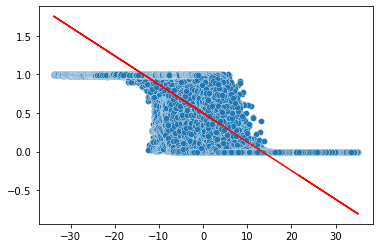

In [20]:
plt.plot(ds_final['t2m'], pred_t2m, c='r')
plt.scatter(ds_final['t2m'], true, marker='o', edgecolor='white', linewidth=0.3)

In [19]:
reg_d2m = smf.ols(formula='snow_frac ~ d2m', data=ds_final).fit()
reg_d2m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              snow_frac   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 2.030e+07
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:11:12   Log-Likelihood:            -1.1518e+06
No. Observations:             9925001   AIC:                         2.304e+06
Df Residuals:                 9924999   BIC:                         2.304e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4098   8.63e-05   4750.660      0.000       0.410       0.410
d2m           -0.0377   8.38e-06  -4505.020      0.000      -0.038      -0.038
==============================================================================
Omnibus:                  1259028.021   Durbin-Watson:                   0.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           458207.156
Skew:                           0.305   Prob(JB):                         0.00
Kurtosis:                       2.142   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
pred_d2m = reg_d2m.fittedvalues.copy()
res_d2m = true - pred_d2m

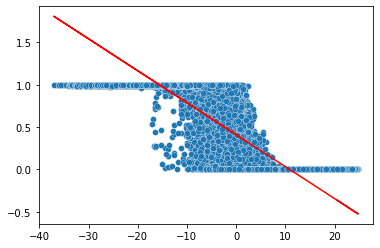

In [23]:
plt.plot(ds_final['d2m'][::50], pred_d2m[::50], c='r')
plt.scatter(ds_final['d2m'][::50], true[::50], marker='o', edgecolor='white', linewidth=0.3)

## Linear Step Fcn

In [20]:
x_t2m_lr = np.linspace(ds_final['t2m'].min(), ds_final['t2m'].max(), 1000)
m_t2m = reg_t2m.params.t2m
b_t2m = reg_t2m.params.Intercept
x0_t2m = (1 - b_t2m)/m_t2m
x1_t2m = -b_t2m/m_t2m
y_t2m_lr = list(map((lambda x: 1 if x <= x0_t2m else (m_t2m*x+b_t2m if x > x0_t2m and x < x1_t2m else 0)), x_t2m_lr))

x_d2m_lr = np.linspace(ds_final['d2m'].min(), ds_final['d2m'].max(), 1000)
m_d2m = reg_d2m.params.d2m
b_d2m = reg_d2m.params.Intercept
x0_d2m = (1 - b_d2m)/m_d2m
x1_d2m = -b_d2m/m_d2m
y_d2m_lr = list(map((lambda x: 1 if x <= x0_d2m else (m_d2m*x+b_d2m if x > x0_d2m and x <= x1_d2m else 0)), x_d2m_lr))

Text(0, 0.5, 'Snow Fraction')

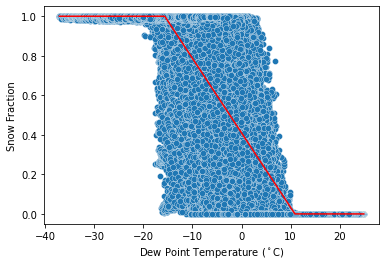

In [25]:
plt.scatter(ds_final['d2m'], true, marker='o', edgecolor='white', linewidth=0.3)
plt.plot(x_d2m_lr, y_d2m_lr, c='r')
plt.xlabel('Dew Point Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')

Text(0, 0.5, 'Snow Fraction')

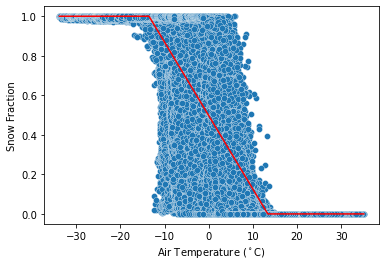

In [26]:
plt.scatter(ds_final['t2m'], true, marker='o', edgecolor='white', linewidth=0.3)
plt.plot(x_t2m_lr, y_t2m_lr, c='r')
plt.xlabel('Air Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')

In [27]:
# def piecewise_linear(x, x0, x1, m, b):
#     return np.piecewise(x, [x <= x0, (x > x0)*(x <= x1), x > x1], [1, lambda x: m*x + b, 0])

# p , e = myfit(piecewise_linear, ds_final['d2m'], ds_final['snow_frac'])

## Logistic Curve Fitting

In [21]:
from scipy.optimize import curve_fit

In [22]:
def logistic4(x, k, mu):
    a = 1 
    c = 0
    return a + (c-a)/(1+np.exp(-k*(x-mu))) 

In [23]:
def myfit(func, x, y):
    xr = x.ravel()
    yr = y.ravel()
    asort = np.argsort(xr)
    popt, pcov = curve_fit(func, xr[asort], yr[asort])
    res = yr[asort]-func(xr[asort], *popt)
    return popt, res # gives error b/w every pred and true point -> useful for validation -> MSE

In [24]:
x_d2m = ds_final['d2m']
x_t2m = ds_final['t2m']
y = ds_final['snow_frac']

params_t2m, resid_t2m = myfit(logistic4, x_t2m, y)

In [25]:
def RMSE(params, calculate_error, yData, resid=None, yPred=None):
    if calculate_error is False and resid is not None:
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    elif calculate_error is True and yPred is not None:
        resid = yData - yPred
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    print('Parameters:', params)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

In [26]:
RMSE(params=params_t2m, calculate_error=False, yData=ds_final['snow_frac'], resid=resid_t2m)

Parameters: [1.36527176 0.98420547]
RMSE: 0.13683318055732402
R-squared: 0.9168287601185284


In [27]:
# plt.scatter(x_t2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original Data', s=20)
# plt.scatter(x_t2m, logistic4(x_t2m, params_t2m[0], params_t2m[1]), color='red', s=1, label= 'Log Fit')
# # plt.legend(loc='upper right')
# plt.xlabel('Air Temperature ($^\circ$C)')
# plt.ylabel('Snow Fraction')
# plt.title('Hourly')

In [28]:
params_d2m, resid_d2m = myfit(logistic4, x_d2m, y)

In [29]:
RMSE(params=params_d2m, calculate_error=False, yData=ds_final['snow_frac'], resid=resid_d2m)

Parameters: [ 1.04581847 -0.56531829]
RMSE: 0.16021515811977177
R-squared: 0.8861444554813546


In [30]:
xx_t2m = np.linspace(x_d2m.min(), x_d2m.max(), 1000)
xx_d2m = np.linspace(x_d2m.min(), x_d2m.max(), 1000)

In [31]:
# plt.scatter(x_d2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
# plt.scatter(x_d2m[::100], logistic4(x_d2m, params_d2m[0], params_d2m[1])[::100], color='red', s=1, label= 'Log')
# plt.legend(loc='lower left')
# plt.xlabel('Dew Point Temperature ($^\circ$C)')
# plt.ylabel('Snow Fraction')
# plt.title('Hourly')

## Isotonic Regression

In [33]:
from sklearn.isotonic import IsotonicRegression

In [34]:
ir_d2m = IsotonicRegression(increasing=False).fit(x_d2m, y)
ir_t2m = IsotonicRegression(increasing=False).fit(x_t2m, y)

# Actual predictions
y_d2m = ir_d2m.predict(x_d2m)
y_t2m = ir_t2m.predict(x_t2m)

# For graphing
yy_d2m = ir_d2m.predict(xx_d2m)
yy_t2m = ir_t2m.predict(xx_t2m)
# Also do MSE for this

In [35]:
RMSE(params=params_d2m, calculate_error=True, yData=ds_final['snow_frac'], yPred=y_d2m)

Parameters: [ 1.04581847 -0.56531829]
RMSE: 0.15878022603431946
R-squared: 0.8878763374469765


In [36]:
RMSE(params=params_t2m, calculate_error=True, yData=ds_final['snow_frac'], yPred=y_t2m)

Parameters: [1.36527176 0.98420547]
RMSE: 0.13597383459400128
R-squared: 0.9177728695724545


In [45]:
# plt.scatter(x_d2m, y,  marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
# plt.scatter(x_d2m[::100], y_d2m[::100], color='green', s=1, label= 'Isotonic')
# plt.legend(loc='lower left')
# plt.xlabel('Dew Point Temperature ($^\circ$C)')
# plt.ylabel('Snow Fraction')
# plt.title('Hourly')

In [46]:
# plt.scatter(x_t2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
# plt.scatter(x_t2m[::100], y_t2m[::100], color='green', s=1, label= 'Isotonic')
# plt.legend(loc='lower left')
# plt.xlabel('Air Temperature ($^\circ$C)')
# plt.ylabel('Snow Fraction')
# plt.title('Hourly')

Text(0, 0.5, 'Snow Fraction')

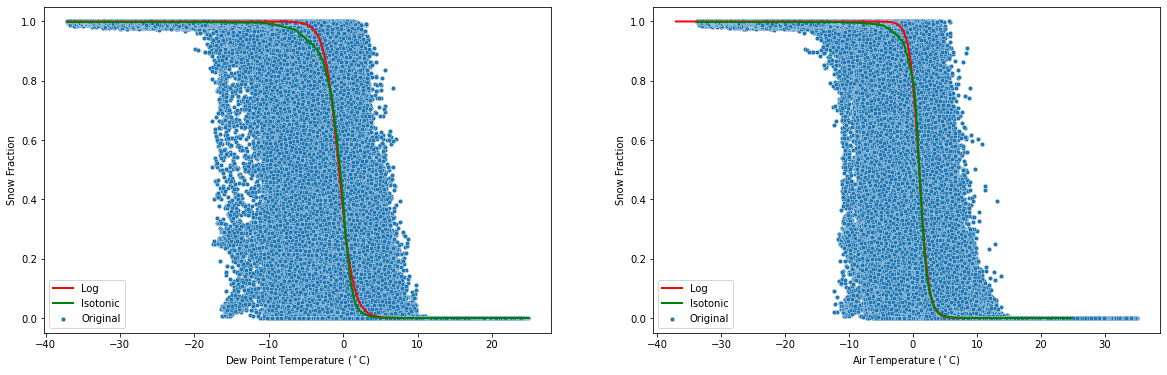

In [47]:
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.scatter(x_d2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
ax.plot(xx_d2m, logistic4(xx_d2m, params_d2m[0], params_d2m[1]), color='red', label= 'Log', linewidth=2)
ax.plot(xx_d2m, yy_d2m, color='green', label= 'Isotonic', linewidth=2)
ax.legend(loc='lower left')
ax.set_xlabel('Dew Point Temperature ($^\circ$C)')
ax.set_ylabel('Snow Fraction')

ax2.scatter(x_t2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20)
ax2.plot(xx_t2m, logistic4(xx_t2m, params_t2m[0], params_t2m[1]), color='red', label= 'Log', linewidth=2)
ax2.plot(xx_t2m, yy_t2m, color='green', label= 'Isotonic', linewidth=2)
ax2.legend(loc='lower left')
ax2.set_xlabel('Air Temperature ($^\circ$C)')
ax2.set_ylabel('Snow Fraction')

In [49]:
# plt.close('all')
# f = plt.figure(figsize=(20,6))
# ax = f.add_subplot(121)
# ax2 = f.add_subplot(122)

# ax.scatter(x_d2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20, alpha=0.01)
# ax.scatter(x_d2m[::100], logistic4(x_d2m, params_d2m[0], params_d2m[1])[::100], color='red', s=1, label= 'Log')
# ax.scatter(x_d2m[::100], y_d2m[::100], color='green', s=1, label= 'Isotonic')
# ax.legend(loc='lower left')
# ax.set_xlabel('Dew Point Temperature ($^\circ$C)')
# ax.set_ylabel('Snow Fraction')

# ax2.scatter(x_t2m, y, marker='o', edgecolor='white', linewidth=0.3, label='Original', s=20, alpha=0.01)
# ax2.scatter(x_t2m[::100], logistic4(x_t2m, params_t2m[0], params_t2m[1])[::100], color='red', s=1, label= 'Log')
# ax2.scatter(x_t2m[::100], y_t2m[::100], color='green', s=1, label= 'Isotonic')
# ax2.legend(loc='lower left')
# ax2.set_xlabel('Air Temperature ($^\circ$C)')
# ax2.set_ylabel('Snow Fraction')

Text(0, 0.5, 'Snow Fraction')

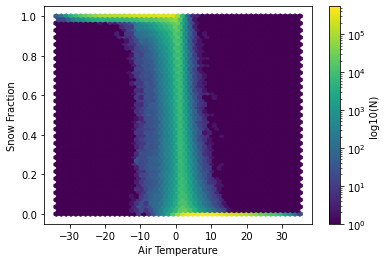

In [50]:
# xmin = x_t2m.min() + 0.5
# xmax = x_t2m.max() - 0.5
# ymin = y.min() - 10
# ymax = y.max() + 10

# hb = plt.hexbin(x_t2m, y, gridsize=50, bins='log')
# plt.xlim=(xmin, xmax)
# plt.ylim=(ymin, ymax)
# cb = plt.colorbar(hb)
# cb.set_label('log10(N)')
# plt.xlabel('Air Temperature')
# plt.ylabel('Snow Fraction')

## Binary Temp. Thresholds

In [ ]:
d2m_pts = pd.DataFrame(
    {"d2m": x_d2m,
     "snow_frac": y_d2m}
)
d2m_pts.reset_index(inplace=True)
d2m_pts.drop(['latitude', 'longitude', 'time'], axis=1, inplace=True)

t2m_pts = pd.DataFrame(
    {"t2m": x_t2m,
     "snow_frac": y_t2m}
)
t2m_pts.reset_index(inplace=True)
t2m_pts.drop(['latitude', 'longitude', 'time'], axis=1, inplace=True)

In [49]:
def find_neighbours(value, df, var):
    exactmatch=df[df.snow_frac==value]
    if exactmatch.empty is False:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df.snow_frac<value].snow_frac.idxmax()
        upperneighbour_ind = df[df.snow_frac>value].snow_frac.idxmin()
        
        lower_diff = np.abs(df.iloc[lowerneighbour_ind, :].snow_frac - 0.5)
        upper_diff = np.abs(df.iloc[upperneighbour_ind, :].snow_frac - 0.5)

        if lower_diff > upper_diff:
            return df.iloc[upperneighbour_ind, :][var]
        else:
            return df.iloc[lowerneighbour_ind, :][var]
    
t2m_thresh = find_neighbours(0.5, t2m_pts, 't2m')
d2m_thresh = find_neighbours(0.5, d2m_pts, 'd2m')

In [50]:
print("Air Temp Threshold:", t2m_thresh)

Air Temp Threshold: 1.0116516113281477


In [51]:
print("Dewpoint Threshold:", d2m_thresh)

Dewpoint Threshold: -0.38400878906247726


In [37]:
t2m_thresh = 1.0116516113281477
d2m_thresh = -0.38400878906247726

In [53]:
# ds_final['precip_type_t2m'] = ds_final['t2m'].map(lambda x: 'snow' if x <= t2m_thresh else 'rain')
# ds_final['precip_type_d2m'] = ds_final['d2m'].map(lambda x: 'snow' if x <= d2m_thresh else 'rain')

MemoryError: Unable to allocate 75.7 MiB for an array with shape (9925001,) and data type uint64

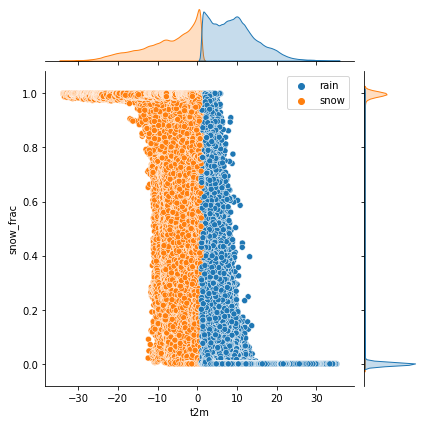

In [52]:
# sns.jointplot(x=ds_final['t2m'], y=ds_final['snow_frac'], hue=ds_final.precip_type_t2m.tolist())

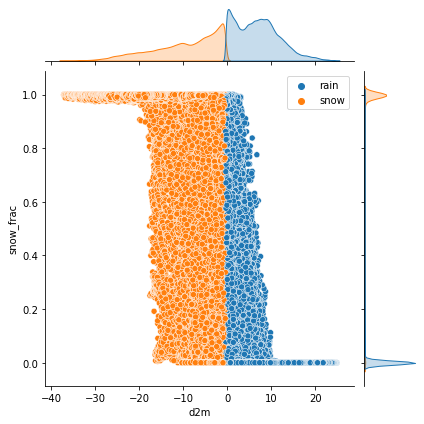

In [53]:
# sns.jointplot(x=ds_final['d2m'], y=ds_final['snow_frac'], hue=ds_final.precip_type_d2m.tolist())

## Binned Statistics

In [38]:
from scipy import stats

In [39]:
def Heaviside(x, a ,b, c): 
    return a * (np.sign(x - b) + c) # Heaviside function

In [37]:
def Binned_Stats(df, variable, lower_temp, upper_temp, test_stat='mean', 
                 plot_histogram=False, interval=0.1, plot_bins=False):  
    # Define temperature bins
    values = np.arange(lower_temp, upper_temp, interval)
    values = [round(i, 1) for i in values]
    
    # Calculate bin statistics
    bin_stats, bin_edges, binnumber = stats.binned_statistic(
        df[variable], 
        df['snow_frac'], 
        statistic='mean', 
        bins=values
    )
    if plot_bins is True:
        plt.figure()
        plt.plot(df[variable], df['snow_frac'], 'c.', label='raw data', alpha=0.005)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='red', lw=5,
                   label='binned statistic of data')
        plt.legend(loc='lower left')
        plt.xlabel(variable)
        plt.ylabel('Snow Fraction')
    
    # Separate snow fraction into temperature-based bins
    bins = [df['snow_frac'][binnumber==i] for i in range(len(values))]
    
    # Concatenate all bins into a single dataframe, with the temperature bin as a multi-index
    bin_df = pd.concat(bins, keys=values, names=[variable])
    return bin_edges, pd.DataFrame(bin_df)

#     target_df = bin_df.iloc[bin_df.index.get_level_values(variable) == target_temp]
#     if plot_histogram is True:
#         target_df.hist(edgecolor='black')
#         plt.title('{} : {} $^\circ$C'.format(variable, target_temp))
#         plt.grid(False)
    
#     if test_stat == 'quantiles' and target_temp is not None:
#         return bin_df, target_df, bin_edges, target_df.quantile(quantiles, axis=0)
#     elif test_stat == 'quantiles' and target_temp is None:
#         print("Error: Target temperature must be specified for 'quantiles'")
#     else:
#         return bin_df, bin_edges, bin_stats

In [38]:
def Binned_Quantiles(df, variable, quantiles, bins):
    quantiles = [df.iloc[df.index.get_level_values(variable) == i].quantile(qts, axis=0) for i in bins]
    quantile_df = pd.concat(quantiles, keys=bins, names=[variable])
    return pd.DataFrame(quantile_df)

In [39]:
bin_edges_d2m, bin_df_d2m = Binned_Stats(ds_final,'d2m', -10, 10)
bin_edges_t2m, bin_df_t2m = Binned_Stats(ds_final, 't2m', -10, 10)

# qts = np.arange(0.1, 1, 0.1)
qts = [0.25, 0.5, 0.75]
quantile_df_d2m = Binned_Quantiles(bin_df_d2m, 'd2m', qts, bin_edges_d2m)
quantile_df_t2m = Binned_Quantiles(bin_df_t2m, 't2m', qts, bin_edges_t2m)

In [40]:
qdf_d2m = quantile_df_d2m.reset_index()
qdf_d2m.rename(columns={'level_1': 'quantile'}, inplace=True)
qdf_d2m['snow_frac'] = qdf_d2m['snow_frac'].map(lambda x: x*100)

qdf_t2m = quantile_df_t2m.reset_index()
qdf_t2m.rename(columns={'level_1': 'quantile'}, inplace=True)
qdf_t2m['snow_frac'] = qdf_t2m['snow_frac'].map(lambda x: x*100)

In [ ]:
sc = sns.lineplot(data=qdf_d2m, x="d2m", y="snow_frac", hue='quantile', palette=['maroon','black','maroon'], linestyle='dashdot')

In [ ]:
sc = sns.lineplot(data=qdf_t2m, x="t2m", y="snow_frac", hue='quantile', palette=['maroon','black','maroon'], linestyle='dashdot')

<ipython-input-43-b38f02898372>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


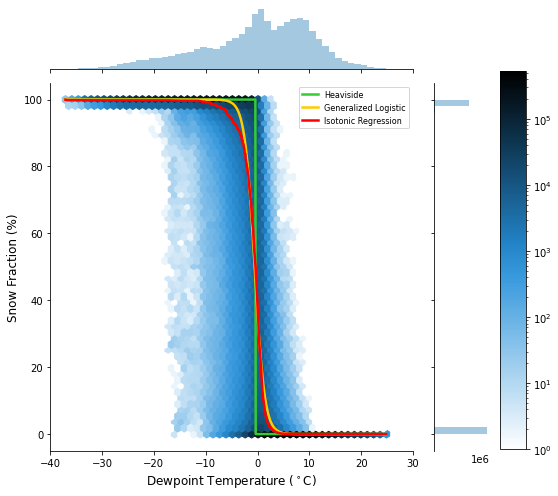

In [43]:
plt.rcParams["axes.labelsize"] = 12
g = sns.jointplot(
    x=ds_final['d2m'], 
    y=ds_final['snow_frac']*100, 
    kind='hex', 
    bins='log', 
    height=7
)
sns.lineplot(
    xx_d2m, 
    Heaviside(xx_d2m, -50, d2m_thresh,-1), 
    color='#33cc33', 
    linewidth=2.5, 
    label='Heaviside', 
    ax=g.ax_joint
)
sns.lineplot(
    x=xx_d2m, 
    y=(logistic4(xx_d2m, params_d2m[0], params_d2m[1]))*100, 
    color='#ffcc00', 
    label= 'Generalized Logistic', 
    ax=g.ax_joint, 
    linewidth=2.5
)
sns.lineplot(
    x=xx_d2m, 
    y=yy_d2m*100, 
    color='red', 
    label= 'Isotonic Regression', 
    ax=g.ax_joint, 
    linewidth=2.5
)
# sns.lineplot(
#     x=x_d2m_lr, 
#     y=[i*100 for i in y_d2m_lr], 
#     color='m', 
#     label= 'Linear Regression', 
#     ax=g.ax_joint, 
#     linewidth=2.5, 
#     linestyle=':'
# )
# sns.lineplot(
#     data=qdf_d2m, 
#     x="d2m", 
#     y="snow_frac", 
#     hue='quantile', 
#     palette=['#003366','black','#003366'], 
#     linestyle=':', 
#     ax=g.ax_joint, 
#     linewidth=2
# )
g.ax_joint.legend(prop={"size": 8}, loc='upper right')
g.ax_joint.set(xlabel='Dewpoint Temperature ($^\circ$C)', ylabel='Snow Fraction (%)', xlim=(-40, 30))
cbar_ax = g.fig.add_axes([1, .1, .05, .75])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.tight_layout()
plt.savefig('d2m_final.png')

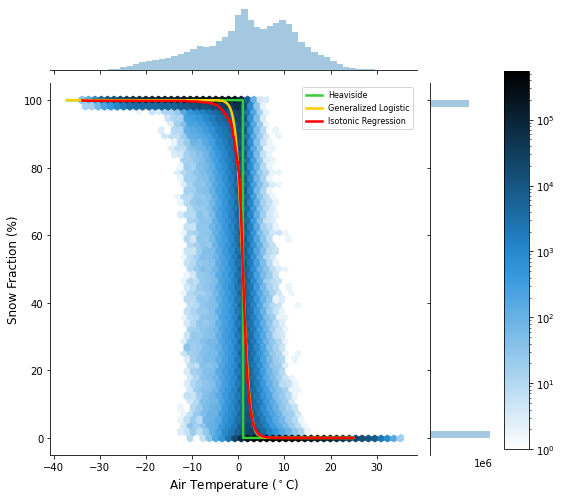

In [46]:
plt.rcParams["axes.labelsize"] = 12
g = sns.jointplot(
    x=ds_final['t2m'], 
    y=ds_final['snow_frac']*100, 
    kind='hex', 
    bins='log',
    height=7
)
sns.lineplot(
    xx_t2m, 
    Heaviside(xx_t2m, -50, t2m_thresh,-1), 
    color='#33cc33', 
    linewidth=2.5, 
    label= 'Heaviside', 
    ax=g.ax_joint
)
sns.lineplot(
    x=xx_t2m, 
    y=(logistic4(xx_t2m, params_t2m[0], params_t2m[1]))*100, 
    color='#ffcc00', 
    label= 'Generalized Logistic', 
    ax=g.ax_joint, 
    linewidth=2.5
)
sns.lineplot(
    x=xx_t2m, 
    y=yy_t2m*100, 
    color='red', 
    label= 'Isotonic Regression', 
    ax=g.ax_joint, 
    linewidth=2.5
)
# sns.lineplot(
#     x=x_t2m_lr, 
#     y=[i*100 for i in y_t2m_lr], 
#     color='#cc3399', 
#     label= 'Linear Regression',
#     ax=g.ax_joint, 
#     linewidth=2.5
# )
# sns.lineplot(
#     data=qdf_t2m, 
#     x="t2m", 
#     y="snow_frac", 
#     hue='quantile', 
#     palette=['#003366','black','#003366'], 
#     linestyle=':', 
#     ax=g.ax_joint, 
#     linewidth=2
# )
g.ax_joint.legend(prop={"size": 8}, loc='upper right')
g.ax_joint.set(xlabel='Air Temperature ($^\circ$C)', ylabel='Snow Fraction (%)')
cbar_ax = g.fig.add_axes([1, .1, .05, .75])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.savefig('t2m_final.png')

# different colour for curve fitting (no blues)->orange/red will be good
# 1 for d2m, and 1 for t2m
# change label names to the full names-> snow frac to % *
# font size increase
# legend for each fitted curve *
# Log-> generalized logistic *
# colorbar + 1e6 at the bottom right